# IGS PGP1f Analysis

Concerning genome architecture in PGP1 fibroblasts. See Fig 2. of Payne, Chiang, Reginato et al.

# 0. Initializations

In [1]:
import os, sys, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.append(os.path.abspath(os.path.join(r"..", r".")))

from scipy.stats import binned_statistic
from source import const
from source import matrixtools as mt
from source import radial as rd
from source import scaling as sc

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}

mpl.rcParams.update(new_rc_params)
mpl.rcParams['figure.dpi']= 300

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
pgp_file = "../data/Table_S1_pgp1_data_table.csv"
pgp_data = pd.read_csv(pgp_file,index_col=False)

num_chrs = len(const.SIZES_HG38)
pgp_data = pgp_data.loc[pgp_data["hg38_chr"] < num_chrs]

#Retreive the single cells
cells = []
cell_indices = pgp_data["cell_id"].unique()
for cell_index in cell_indices:
    cells.append(pgp_data.loc[pgp_data["cell_id"] == cell_index])

# 1. Genome-wide distance matrix

Pariwise distances for all chromosomes in the PGP1f ensemble of cells.

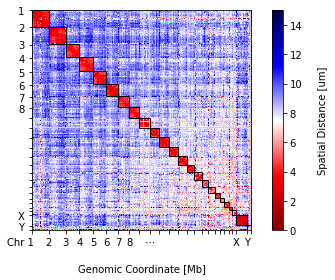

<Figure size 432x288 with 0 Axes>

In [3]:
#get all euclidean distances b/w reads in single cells, genome-wide at target resolution
A = mt.make_genome_wide_matrix(cells, resolution = 10*10**6) 
A = mt.flatten_matrix(A) #compute distance metric elementwise on first maatrix, metric defaults to mean
fig, ax = mt.draw_genome_wide_matrix(A)
plt.savefig("./panel_d_matrix/matrix.svg")

# 2. Radial distances

Relative radial distances for all chromosomes in the PGP1f ensemble.

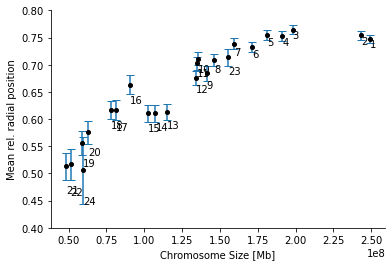

In [4]:
R = rd.get_radial_dists(cells) # all distances per chromosome
R_mean = rd.get_radial_statistic(R)
CIs = rd.get_radial_CIs(R,R_mean, bounds=0.95) 
fig, ax = rd.draw_radial_plot(R_mean, CIs)
plt.savefig("./panel_e_radial/radial.svg")

# 3. Chromosome arms

Compare distances with and between p and q arms.

In [5]:
def do_arm_analysis(cells, target_chr,
                   bin_threshold=20,
                   upper_cutoff_q=99.9,
                   resolution=1*10**6):

    #Get the list of clusters (single chromosome copies)
    clusters, cells_clusters = sc.cluster_helper(cells,[target_chr])
    #Get pairwise spatial and genomic distances within and between their arms
    R_inter, P_inter, R_intra, P_intra = sc.get_arm_distances(clusters, target_chr)
    
    num_bins = int(np.ceil(const.SIZES_HG38[target_chr]/resolution))
    bins = np.arange(0,num_bins)*resolution

    #Get their summary statistics per bin
    intra_curve, intra_edges, intra_binnumber = binned_statistic(P_intra, R_intra, bins=bins,statistic=np.nanmean)
    inter_curve, inter_edges, inter_binnumber = binned_statistic(P_inter, R_inter, bins=bins,statistic=np.nanmean)
    intra_std, intra_edges, intra_binnumber = binned_statistic(P_intra, R_intra, bins=bins,statistic=np.nanstd)
    inter_std, inter_edges, inter_binnumber = binned_statistic(P_inter, R_inter, bins=bins,statistic=np.nanstd)
    
    #Find the bins with reasonable sampling depths
    inter_threshold, intra_threshold = np.zeros(num_bins), np.zeros(num_bins)
    for bn in inter_binnumber: inter_threshold[bn] += 1
    for bn in intra_binnumber: intra_threshold[bn] += 1
    inter_inds = np.nonzero(inter_threshold > bin_threshold)
    intra_inds = np.nonzero(intra_threshold > bin_threshold)
    
    #Plot the bin summary stats
    x = (inter_edges[inter_inds], intra_edges[intra_inds])
    y = (inter_curve[inter_inds], intra_curve[intra_inds])
    yerr = (inter_std[inter_inds], intra_std[intra_inds])
    fig, ax = sc.draw_arm_curves(x,y,yerr)
    plt.savefig("./panel_i_arms/arms.svg")

    #Now find bins where both types of measurement are present
    shared_inds = np.intersect1d(intra_inds, inter_inds)

    #Get the observed distances in those bins
    shared_intra_inds = [i for i, val in enumerate(intra_binnumber) if val in set(shared_inds)]
    shared_inter_inds = [i for i, val in enumerate(inter_binnumber) if val in set(shared_inds)]
    shared_R_intra = R_intra[shared_intra_inds]
    shared_R_inter = R_inter[shared_inter_inds]
    
    #Threshold distanes to remove extreme outliers (e.g. mislabeled or extrachromosomal points)
    thresh = np.percentile(shared_R_intra, upper_cutoff_q)
    shared_R_intra = np.array([i for i in shared_R_intra if i <= thresh])
    
    thresh = np.percentile(shared_R_inter, upper_cutoff_q)
    shared_R_inter = np.array([i for i in shared_R_inter if i <= thresh])
    
    fig2, ax2 = sc.draw_arm_violins(shared_R_inter, shared_R_intra)
    plt.savefig("./panel_j_comp/comp_arms.svg")
    
    return fig, ax, fig2, ax2

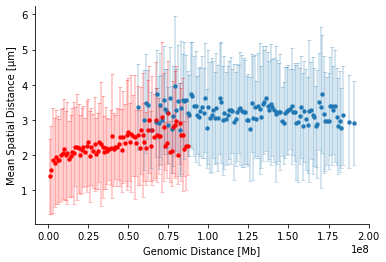

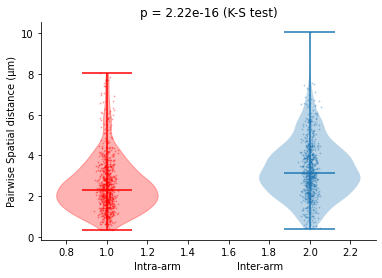

In [6]:
target_chr = 1
fig, ax, fig2, ax2 = do_arm_analysis(cells, target_chr)